# benchmark simple sum dataset using grok function calling

We hoped to use GROQ inference API to compare models for free.  

In reality, we find that tool calling is not working very well, the API often fails to use the tool call.  

We will make a subsequent notebook to use the single token output method for evaluation instead.  

The only model evaluated here is `llama3-70b-8192`.  

## install libs

In [64]:
!pip install groq

In [65]:
from google.colab import userdata
from groq import BadRequestError, RateLimitError
from groq import Groq
import os
import json

client = Groq(api_key = userdata.get('GROQ_API_KEY'))
MODEL = 'llama3-70b-8192'

import time

def get_sum_result(current_sum, curr_model):
    max_retries = 3
    for attempt in range(max_retries):
        try:
            # Step 1: send the conversation and available functions to the model
            messages = [
                {
                    "role": "system",
                    "content": "You are a function calling LLM that uses function record_answer to record sum answers."
                },
                {
                    "role": "user",
                    "content": f"Perform this sum: {current_sum}",
                }
            ]
            tools = [
                {
                    "type": "function",
                    "function": {
                        "name": "record_answer",
                        "description": "get the answer to the question",
                        "parameters": {
                            "type": "object",
                            "properties": {
                                "result": {
                                    "type": "integer",
                                    "description": "the result of the sum",
                                }
                            },
                            "required": ["result"],
                        },
                    },
                }
            ]
            response = client.chat.completions.create(
                model=curr_model,
                messages=messages,
                tools=tools,
                tool_choice={"type": "function", "function": {"name": "record_answer"}},
                max_tokens=4096
            )

            response_message = response.choices[0].message
            tool_calls = response_message.tool_calls

            try:
                result = json.loads(tool_calls[0].function.arguments)['result']
                return result
            except Exception as e:
                return 0  # We return 0 if we fail to parse a JSON answer
        except RateLimitError as e:
                time.sleep(1)
        except BadRequestError as e:
            if attempt < max_retries - 1:
                time.sleep(1)
                continue
            else:
                raise Exception("Max retries exceeded") from e

result = get_sum_result("1+1", 'llama3-8b-8192')
print(result)


2


In [66]:
import pandas as pd

addition_list = []
ones_list = []
for i in range(100):
  ones_list.append('1')
  addition_list.append({
      'sum' : '+'.join(ones_list),
      'result' : str(i+1)
      })

additions_df = pd.DataFrame(addition_list)

# we remove the first line that doesn't contain a sum (single one)
additions_df = additions_df[additions_df['result'] != '1']
additions_df.reset_index(drop=True, inplace=True)

additions_df.head()


,sum,result
0,1+1,2
1,1+1+1,3
2,1+1+1+1,4
3,1+1+1+1+1,5
4,1+1+1+1+1+1,6


In [67]:
from functools import partial
import concurrent.futures
from tqdm.auto import tqdm
import seaborn as sns
import matplotlib.pyplot as plt


def perform_parallel_sums(sums_to_compute, model_name):
    # Number of parallel calls
    N = 4

    # Create a partial function with model_name argument
    partial_get_sum_result = partial(get_sum_result, curr_model=model_name)

    # Create a ThreadPoolExecutor
    with concurrent.futures.ThreadPoolExecutor(max_workers=N) as executor:
        # Wrap the executor.map with tqdm for progress bar
        inferred_sums = list(tqdm(executor.map(partial_get_sum_result, sums_to_compute), total=len(sums_to_compute)))

    return inferred_sums

def get_benchmark_df(df, models_to_test, number_of_samples=10):

  inferred_sums = []
  for curr_model in tqdm(models_to_test, desc='inferring on models'):
      inferred_sums.append(perform_parallel_sums(df['sum'].tolist()[:number_of_samples], curr_model))

  df_list = []
  df_list.append(df.head(number_of_samples))

  for inference_results, model_name in zip(inferred_sums, models_to_test):
    df_list.append(pd.DataFrame(inference_results, columns=[model_name]))
  return pd.concat(df_list, axis=1)

def analyze_model(df, model_name):
  df = df.copy(deep=True)

  # count parsing failures
  number_of_parsing_failures = len(df[df[model_name] == 0])

  # compute accuracy including JSON parse errors as bad answers
  df['is_correct'] = df['result'].astype(int) == df[model_name]
  mean_accuracy = df.is_correct.mean()*100

  # exclude parsing failures from stat count as "0" is not a significant result to measure
  df = df[df[model_name] != 0]

  # select the failed results to compute error stats
  wrong_answers = df[df.is_correct == False].copy(deep=True)


  if len(wrong_answers) == 0:
    return {
        'model_name' : model_name,
        'avg_accuracy' : mean_accuracy,
        'error_mean' : 0,
        'error_median' : 0,
        'error_std' : 0,
        'error_min' : 0,
        'error_max' : 0,
        'parsing_failure_count' : number_of_parsing_failures
    }
  else:
    wrong_answers['error_abs'] = abs(wrong_answers['result'].astype(int) - wrong_answers[model_name])
    wrong_answers['error_prop'] = wrong_answers['error_abs'] / wrong_answers['result'].astype(int)
    return {
        'model_name' : model_name,
        'avg_accuracy' : mean_accuracy,
        'error_mean' : wrong_answers['error_abs'].mean(),
        'error_median' : wrong_answers['error_abs'].median(),
        'error_std' : wrong_answers['error_abs'].std(),
        'error_min' : wrong_answers['error_abs'].min(),
        'error_max' : wrong_answers['error_abs'].max(),
        'parsing_failure_count' : number_of_parsing_failures
    }

def get_stats_recap(benchmark_df, models_to_test):
  results = []
  for model_name in models_to_test:
    results.append(analyze_model(benchmark_df, model_name))

  return pd.DataFrame(results)

def show_model_results(df, model_name):
  df['is_correct'] = df['result'].astype(int) == df[model_name]

  sns.set_theme(style="whitegrid")

  # Order the results
  results = df['result'].astype(int).unique()
  results.sort()

  # set the high and width
  plt.figure(figsize=(20, 2))

  # Create the barplot
  g = sns.barplot(x="result", y=[1]*len(df), data=df, order=results, hue="is_correct", palette={False:"#EA5455", True:"#34A853"})

  # pivot label
  g.set_xticklabels(g.get_xticklabels(), rotation=90, ha="right")

  # Add title and labels
  plt.title(f"Model : {model_name} - Position of correct sums")
  plt.xlabel("Sum")
  plt.show()


In [68]:
# USING GROQ: we hit either severe rate limits, or an inability to use tools correctly.
models_to_test = [
  # 'gemma-7b-it',
  # 'mixtral-8x7b-32768',
  # 'llama3-8b-8192',
  'llama3-70b-8192',
]

number_of_samples = 100

benchmark_df = get_benchmark_df(additions_df, models_to_test, number_of_samples)
benchmark_df.head()

inferring on models:   0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

,sum,result,llama3-70b-8192
0,1+1,2,2.0
1,1+1+1,3,3.0
2,1+1+1+1,4,4.0
3,1+1+1+1+1,5,5.0
4,1+1+1+1+1+1,6,6.0


In [69]:
get_stats_recap(benchmark_df, models_to_test)

,model_name,avg_accuracy,error_mean,error_median,error_std,error_min,error_max,parsing_failure_count
0,llama3-70b-8192,14.141414,28.328125,26.5,21.893722,1.0,70.0,0


<ipython-input-67-27a433533765>:100: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_xticklabels(g.get_xticklabels(), rotation=90, ha="right")


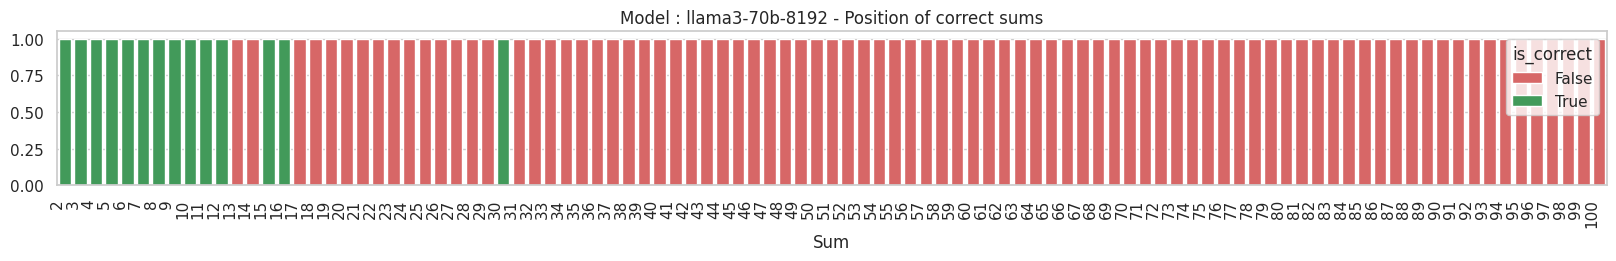

In [70]:
for curr_model in models_to_test:
  show_model_results(benchmark_df, curr_model)